### Dependencies

In [1]:
from utils import MultiTaskDataset, MultiTaskClassifier, ASTBackbone, get_device, SpectrogramDataset, CLASS_MAPPING, set_seed, test_model, create_folder, train_multi_task_learning
import torch.optim as optim
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split

DATA_PATH = "/home/alex/Downloads/archive(2)/data/"
EPOCHS = 40
LR = 1e-2
BATCH_SIZE = 8
RANDOM_SEED = 42
NUM_CATEGORIES = 1
DEVICE = get_device()


create_folder("model_weights"), create_folder("assets")

(None, None)

### Data preparation

In [2]:
valence_data = SpectrogramDataset(DATA_PATH + "multitask_dataset/", class_mapping=CLASS_MAPPING, train=True, regression=1)
energy_data = SpectrogramDataset(DATA_PATH + "multitask_dataset/", class_mapping=CLASS_MAPPING, train=True, regression=2)
dancability_data = SpectrogramDataset(DATA_PATH + "multitask_dataset/", class_mapping=CLASS_MAPPING, train=True, regression=3)

In [3]:
multi_task_labels = []
for valence_y, energy_y, dancability_y in zip(valence_data.labels, energy_data.labels, dancability_data.labels):
    multi_task_labels.append((valence_y, energy_y, dancability_y))
np.array(multi_task_labels)

array([[0.578, 0.973, 0.873],
       [0.839, 0.782, 0.655],
       [0.587, 0.956, 0.204],
       ...,
       [0.337, 0.592, 0.316],
       [0.536, 0.404, 0.366],
       [0.477, 0.949, 0.431]])

In [4]:
multi_task_dataset = MultiTaskDataset(features=valence_data.feats, labels=np.array(multi_task_labels))

# split data into train and val set
train_size = int(0.8 * len(multi_task_dataset))
val_size = len(multi_task_dataset) - train_size
train_dataset, val_dataset = random_split(multi_task_dataset, [train_size, val_size])

train_dl = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Overfit model on one batch to make sure everything works

In [5]:
set_seed(RANDOM_SEED)
backbone = ASTBackbone(
    fstride=10,
    tstride=10,
    input_fdim=dancability_data[0][0].shape[1],
    input_tdim=dancability_data[0][0].shape[0],
    imagenet_pretrain=False,
    model_size='tiny224',
    feature_size=1
)

set_seed(RANDOM_SEED)
model = MultiTaskClassifier(num_tasks=3, backbone=backbone, task_feature_sizes=[1, 1, 1])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)  # Every 10 epochs, reduce LR by factor of 0.7
inputs, targets, lengths = next(iter(train_dl))
inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
model.to(DEVICE)
for epoch in range(50):
    model.train()
    optimizer.zero_grad()
    loss, losses, logits = model(inputs.float(), targets.float())
    loss.backward()
    # clip gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    if epoch == 0 or (epoch+1)%5 == 0:
        loss1, loss2, loss3 = losses
        print(f'Epoch {epoch+1}\n\tTotal Loss at training set: {loss.item()}\n\t{loss1.item()}, {loss2.item()}, {loss3.item()}')


Epoch 1
	Total Loss at training set: 0.7186497449874878
	0.35820311307907104, 0.14091750979423523, 0.21952912211418152
Epoch 5
	Total Loss at training set: 0.5528228282928467
	0.1660214364528656, 0.32223770022392273, 0.06456369906663895
Epoch 10
	Total Loss at training set: 0.3833265006542206
	0.07099781930446625, 0.23726999759674072, 0.07505866140127182
Epoch 15
	Total Loss at training set: 0.31127363443374634
	0.062445178627967834, 0.1584794819355011, 0.0903489887714386
Epoch 20
	Total Loss at training set: 0.29016512632369995
	0.06424452364444733, 0.17305240035057068, 0.05286818742752075
Epoch 25
	Total Loss at training set: 0.23960676789283752
	0.048629775643348694, 0.1310407966375351, 0.05993620306253433
Epoch 30
	Total Loss at training set: 0.2175665944814682
	0.04794362187385559, 0.12798015773296356, 0.041642818599939346
Epoch 35
	Total Loss at training set: 0.19896823167800903
	0.04433393478393555, 0.11097582429647446, 0.04365846514701843
Epoch 40
	Total Loss at training set: 0

### Train Randomly Initialized Model

In [6]:
set_seed(RANDOM_SEED)
backbone = ASTBackbone(
    fstride=10,
    tstride=10,
    input_fdim=dancability_data[0][0].shape[1],
    input_tdim=dancability_data[0][0].shape[0],
    imagenet_pretrain=False,
    model_size='tiny224',
    feature_size=1
)

set_seed(RANDOM_SEED)
model = MultiTaskClassifier(num_tasks=3, backbone=backbone, task_feature_sizes=[1, 1, 1])

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-10)

train_losses, val_losses = train_multi_task_learning(epochs=EPOCHS,
                          device=DEVICE,
                          train_dl=train_dl,
                          val_dl=val_dl,
                          model=model,
                          optimizer=optimizer,
                          scheduler=scheduler,
                          save_path="model_weights/ast_multi_task_best.pth")


Training started for model model_weights/ast_multi_task_best...


100%|██████████| 113/113 [01:01<00:00,  1.85it/s]


Epoch 1
Training Metrics
		Average Total Loss:  0.76
		Average Valence Loss:  0.52
		Average Energy Loss:  0.15
		Average Danceability Loss:  0.09
Evaluation Metrics
		Average Total Loss:  0.16
		Average Valence Loss:  0.06
		Average Energy Loss:  0.07
		Average Danceability Loss:  0.03


100%|██████████| 113/113 [01:01<00:00,  1.83it/s]


Epoch 2
Training Metrics
		Average Total Loss:  0.18
		Average Valence Loss:  0.08
		Average Energy Loss:  0.07
		Average Danceability Loss:  0.03
Evaluation Metrics
		Average Total Loss:  0.16
		Average Valence Loss:  0.06
		Average Energy Loss:  0.07
		Average Danceability Loss:  0.03


100%|██████████| 113/113 [01:02<00:00,  1.82it/s]


Epoch 3
Training Metrics
		Average Total Loss:  0.17
		Average Valence Loss:  0.07
		Average Energy Loss:  0.07
		Average Danceability Loss:  0.03
Evaluation Metrics
		Average Total Loss:  0.16
		Average Valence Loss:  0.07
		Average Energy Loss:  0.07
		Average Danceability Loss:  0.03


100%|██████████| 113/113 [01:01<00:00,  1.82it/s]


Epoch 4
Training Metrics
		Average Total Loss:  0.17
		Average Valence Loss:  0.07
		Average Energy Loss:  0.07
		Average Danceability Loss:  0.03
Evaluation Metrics
		Average Total Loss:  0.15
		Average Valence Loss:  0.06
		Average Energy Loss:  0.07
		Average Danceability Loss:  0.03


100%|██████████| 113/113 [01:01<00:00,  1.82it/s]


Epoch 5
Training Metrics
		Average Total Loss:  0.17
		Average Valence Loss:  0.07
		Average Energy Loss:  0.07
		Average Danceability Loss:  0.03
Evaluation Metrics
		Average Total Loss:  0.17
		Average Valence Loss:  0.07
		Average Energy Loss:  0.07
		Average Danceability Loss:  0.03


100%|██████████| 113/113 [01:02<00:00,  1.82it/s]


Epoch 6
Training Metrics
		Average Total Loss:  0.17
		Average Valence Loss:  0.07
		Average Energy Loss:  0.07
		Average Danceability Loss:  0.03
Evaluation Metrics
		Average Total Loss:  0.15
		Average Valence Loss:  0.06
		Average Energy Loss:  0.07
		Average Danceability Loss:  0.03


100%|██████████| 113/113 [01:01<00:00,  1.83it/s]


Epoch 7
Training Metrics
		Average Total Loss:  0.17
		Average Valence Loss:  0.07
		Average Energy Loss:  0.07
		Average Danceability Loss:  0.03
Evaluation Metrics
		Average Total Loss:  0.16
		Average Valence Loss:  0.06
		Average Energy Loss:  0.07
		Average Danceability Loss:  0.03


100%|██████████| 113/113 [01:01<00:00,  1.83it/s]


Epoch 8
Training Metrics
		Average Total Loss:  0.17
		Average Valence Loss:  0.07
		Average Energy Loss:  0.07
		Average Danceability Loss:  0.03
Evaluation Metrics
		Average Total Loss:  0.16
		Average Valence Loss:  0.06
		Average Energy Loss:  0.07
		Average Danceability Loss:  0.03


100%|██████████| 113/113 [01:01<00:00,  1.83it/s]


Epoch 9
Training Metrics
		Average Total Loss:  0.17
		Average Valence Loss:  0.07
		Average Energy Loss:  0.07
		Average Danceability Loss:  0.03
Evaluation Metrics
		Average Total Loss:  0.16
		Average Valence Loss:  0.06
		Average Energy Loss:  0.07
		Average Danceability Loss:  0.03


100%|██████████| 113/113 [01:01<00:00,  1.83it/s]


Epoch 10
Training Metrics
		Average Total Loss:  0.17
		Average Valence Loss:  0.07
		Average Energy Loss:  0.07
		Average Danceability Loss:  0.03
Evaluation Metrics
		Average Total Loss:  0.16
		Average Valence Loss:  0.06
		Average Energy Loss:  0.07
		Average Danceability Loss:  0.03


100%|██████████| 113/113 [01:01<00:00,  1.82it/s]


Epoch 11
Training Metrics
		Average Total Loss:  0.17
		Average Valence Loss:  0.07
		Average Energy Loss:  0.07
		Average Danceability Loss:  0.03
Evaluation Metrics
		Average Total Loss:  0.15
		Average Valence Loss:  0.06
		Average Energy Loss:  0.07
		Average Danceability Loss:  0.03
Early Stopping was activated.
Training has been completed.



In [7]:
def plot_losses(losses, save_title, title, xlab, ylab):
  fig = plt.figure(figsize=(5, 4))

  plt.plot(losses["Valence Loss"], color="green", label="Avg Valence Loss")
  plt.plot(losses["Energy Loss"], color="blue", label="Avg Energy Loss")
  plt.plot(losses["Danceability Loss"], color="orange", label="Avg Danceability Loss")
  plt.plot(losses["Total Loss"], color="red", label="Avg Total Loss")

  plt.legend()
  plt.title(title)
  plt.xlabel(xlab)
  plt.ylabel(ylab)
  plt.savefig(save_title, dpi=300)
  plt.show()


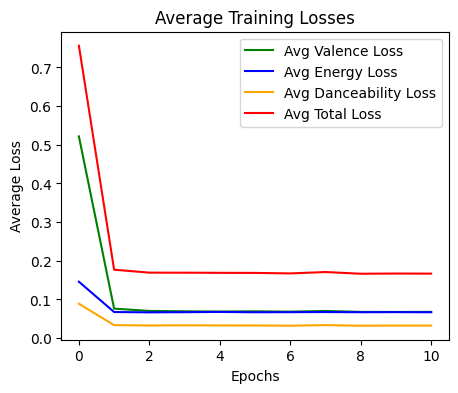

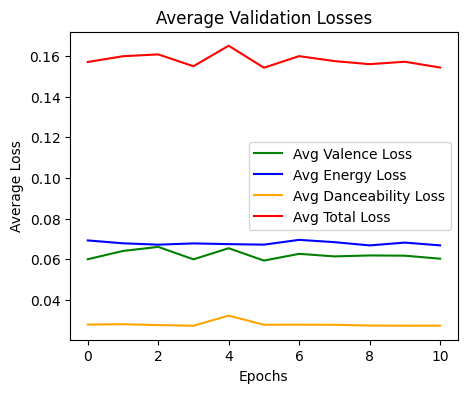

In [8]:
plot_losses(losses=train_losses,
            save_title="assets/multi_task_train_losses.png",
            title="Average Training Losses", xlab="Epochs", ylab="Average Loss")

plot_losses(losses=val_losses,
            save_title="assets/multi_task_val_losses.png",
            title="Average Validation Losses", xlab="Epochs", ylab="Average Loss")

In [ ]:
print("LSTM evaluation on Mel Spectograms")
backbone = LSTMBackbone(mel_specs_data.feat_dim, rnn_size=RNN_HIDDEN_SIZE, num_layers=NUM_LAYERS, bidirectional=True)
model = Classifier(NUM_CATEGORIES, backbone)
model.load_state_dict(torch.load("model_weights/lstm_genre_mel.pth", weights_only=True, map_location=DEVICE))
mel_y_true, mel_y_pred = test_model(model, mel_specs_test_dl, DEVICE)
get_classification_report(y_pred=np.hstack(mel_y_pred), y_true=np.hstack(mel_y_true))
del mel_specs_train_dl, mel_specs_val_dl, mel_specs_test_data, mel_specs_test_dl

In [5]:
backbone = ASTBackbone(
    fstride=10,
    tstride=10,
    input_fdim=dancability_data[0][0].shape[1],
    input_tdim=dancability_data[0][0].shape[0],
    imagenet_pretrain=False,
    model_size='tiny224',
    feature_size=1
)
model = MultiTaskClassifier(num_tasks=3, backbone=backbone, task_feature_sizes=[1, 1, 1])
model.load_state_dict(torch.load("model_weights/ast_multi_task_best.pth", weights_only=True, map_location=DEVICE))
y_true, y_pred, spear_corrs, pear_corrs = test_model(model, val_dl, DEVICE, regression_flag=True, is_multitask=True)

TypeError: forward() takes 3 positional arguments but 4 were given

### Finetune ImageNet Pretrained Model

In [9]:
set_seed(RANDOM_SEED)
backbone = ASTBackbone(
    fstride=10,
    tstride=10,
    input_fdim=dancability_data[0][0].shape[1],
    input_tdim=dancability_data[0][0].shape[0],
    imagenet_pretrain=True,
    model_size='tiny224',
    feature_size=1
)

set_seed(RANDOM_SEED)
model = MultiTaskClassifier(num_tasks=3, backbone=backbone, task_feature_sizes=[1, 1, 1])

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-10)

train_losses, val_losses = train_multi_task_learning(epochs=EPOCHS,
                          device=DEVICE,
                          train_dl=train_dl,
                          val_dl=val_dl,
                          model=model,
                          optimizer=optimizer,
                          scheduler=scheduler,
                          save_path="model_weights/ast_multi_task_best_pre.pth")


Downloading: "https://dl.fbaipublicfiles.com/deit/deit_tiny_distilled_patch16_224-b40b3cf7.pth" to /root/.cache/torch/hub/checkpoints/deit_tiny_distilled_patch16_224-b40b3cf7.pth


Training started for model model_weights/ast_multi_task_best_pre...


100%|██████████| 113/113 [01:01<00:00,  1.83it/s]


Epoch 1
Training Metrics
		Average Total Loss:  0.73
		Average Valence Loss:  0.51
		Average Energy Loss:  0.13
		Average Danceability Loss:  0.09
Evaluation Metrics
		Average Total Loss:  0.16
		Average Valence Loss:  0.06
		Average Energy Loss:  0.07
		Average Danceability Loss:  0.03


100%|██████████| 113/113 [01:01<00:00,  1.83it/s]


Epoch 2
Training Metrics
		Average Total Loss:  0.18
		Average Valence Loss:  0.08
		Average Energy Loss:  0.07
		Average Danceability Loss:  0.03
Evaluation Metrics
		Average Total Loss:  0.16
		Average Valence Loss:  0.06
		Average Energy Loss:  0.07
		Average Danceability Loss:  0.03


100%|██████████| 113/113 [01:01<00:00,  1.84it/s]


Epoch 3
Training Metrics
		Average Total Loss:  0.17
		Average Valence Loss:  0.07
		Average Energy Loss:  0.07
		Average Danceability Loss:  0.03
Evaluation Metrics
		Average Total Loss:  0.16
		Average Valence Loss:  0.07
		Average Energy Loss:  0.07
		Average Danceability Loss:  0.03


100%|██████████| 113/113 [01:01<00:00,  1.84it/s]


Epoch 4
Training Metrics
		Average Total Loss:  0.17
		Average Valence Loss:  0.07
		Average Energy Loss:  0.07
		Average Danceability Loss:  0.03
Evaluation Metrics
		Average Total Loss:  0.16
		Average Valence Loss:  0.06
		Average Energy Loss:  0.07
		Average Danceability Loss:  0.03


100%|██████████| 113/113 [01:01<00:00,  1.83it/s]


Epoch 5
Training Metrics
		Average Total Loss:  0.17
		Average Valence Loss:  0.07
		Average Energy Loss:  0.07
		Average Danceability Loss:  0.03
Evaluation Metrics
		Average Total Loss:  0.17
		Average Valence Loss:  0.07
		Average Energy Loss:  0.07
		Average Danceability Loss:  0.03


100%|██████████| 113/113 [01:01<00:00,  1.83it/s]


Epoch 6
Training Metrics
		Average Total Loss:  0.17
		Average Valence Loss:  0.07
		Average Energy Loss:  0.07
		Average Danceability Loss:  0.03
Evaluation Metrics
		Average Total Loss:  0.15
		Average Valence Loss:  0.06
		Average Energy Loss:  0.07
		Average Danceability Loss:  0.03


100%|██████████| 113/113 [01:01<00:00,  1.83it/s]


Epoch 7
Training Metrics
		Average Total Loss:  0.17
		Average Valence Loss:  0.07
		Average Energy Loss:  0.07
		Average Danceability Loss:  0.03
Evaluation Metrics
		Average Total Loss:  0.16
		Average Valence Loss:  0.06
		Average Energy Loss:  0.07
		Average Danceability Loss:  0.03


100%|██████████| 113/113 [01:01<00:00,  1.83it/s]


Epoch 8
Training Metrics
		Average Total Loss:  0.17
		Average Valence Loss:  0.07
		Average Energy Loss:  0.07
		Average Danceability Loss:  0.03
Evaluation Metrics
		Average Total Loss:  0.16
		Average Valence Loss:  0.06
		Average Energy Loss:  0.07
		Average Danceability Loss:  0.03


100%|██████████| 113/113 [01:01<00:00,  1.83it/s]


Epoch 9
Training Metrics
		Average Total Loss:  0.17
		Average Valence Loss:  0.07
		Average Energy Loss:  0.07
		Average Danceability Loss:  0.03
Evaluation Metrics
		Average Total Loss:  0.16
		Average Valence Loss:  0.06
		Average Energy Loss:  0.07
		Average Danceability Loss:  0.03


100%|██████████| 113/113 [01:01<00:00,  1.83it/s]


Epoch 10
Training Metrics
		Average Total Loss:  0.17
		Average Valence Loss:  0.07
		Average Energy Loss:  0.07
		Average Danceability Loss:  0.03
Evaluation Metrics
		Average Total Loss:  0.16
		Average Valence Loss:  0.06
		Average Energy Loss:  0.07
		Average Danceability Loss:  0.03


100%|██████████| 113/113 [01:01<00:00,  1.83it/s]


Epoch 11
Training Metrics
		Average Total Loss:  0.17
		Average Valence Loss:  0.07
		Average Energy Loss:  0.07
		Average Danceability Loss:  0.03
Evaluation Metrics
		Average Total Loss:  0.15
		Average Valence Loss:  0.06
		Average Energy Loss:  0.07
		Average Danceability Loss:  0.03
Early Stopping was activated.
Training has been completed.



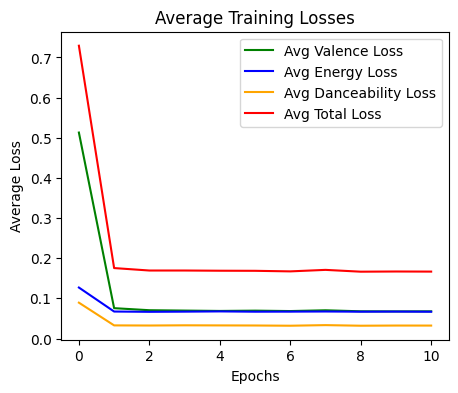

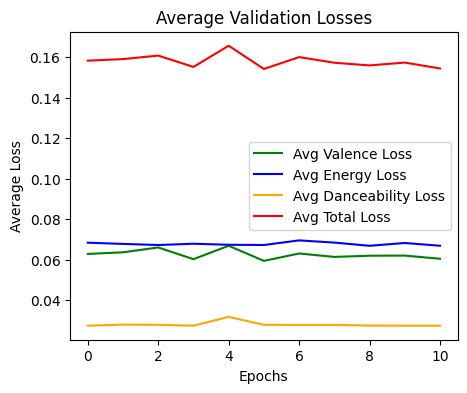

In [10]:
plot_losses(losses=train_losses,
            save_title="assets/multi_task_train_losses_pre.png",
            title="Average Training Losses", xlab="Epochs", ylab="Average Loss")

plot_losses(losses=val_losses,
            save_title="assets/multi_task_val_losses_pre.png",
            title="Average Validation Losses", xlab="Epochs", ylab="Average Loss")